# Classification 

## MNIST 

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Taking a peak at one of the digits from the dataset 

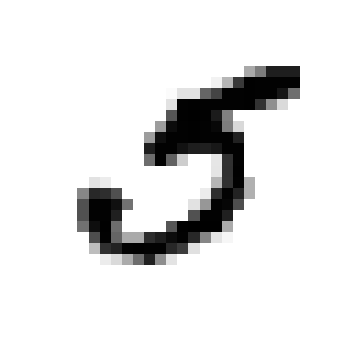

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
y[36000]

5.0

In [5]:
# creating test set and train set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# shuffling the training set so that all CV folds will be similar
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier 

Getting started by seeing if one of the images is a five or not 

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [8]:
# training a Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Performance Measure 

### Measuring Accuracy using Cross-Validation 

In [10]:
# evaluating the SGDClassifier with K-fold cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.94785,  0.9362 ,  0.9453 ])

In [11]:
# creating classifier that says every number is not 5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.91075,  0.911  ,  0.9072 ])

The accuracy is over 90% because only 10% of the images are 5s 

### Confusion Matrix 

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
# producing confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52092,  2487],
       [  926,  4495]])

### Precision and Recall 

In [15]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 4495 / (4495 + 2487)
print(recall_score(y_train_5, y_train_pred)) # == 4495 / (926 + 4495)

0.643798338585
0.8291828076


The 5-dector has high precision and low recall. When it claims an image represents a 5, it is correct 87% of the time. However, it only detects 69% of the 5s. 

In [16]:
# computing f1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.72482463920019347

### Precision/Recall Tradeoff 

In [17]:
# SKLearn doesn't let you set the threshold directly
# Instead of calling the classifier's predict() method we call
# its decision_function(), which returns a score for each instance
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ 65633.72449137]
[ True]


The SGDClassifier uses a default threshold equal to 0 so the code above returns that same result as predict() 

In [18]:
# raising the threshold
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

Increasing the threshold decreases recall. The image actually represents a 5, and the classifier dectects it when the threshold is 0, but misses it when the threshold is increased to 200,000 

In [19]:
# getting the scores of all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [20]:
# computing precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

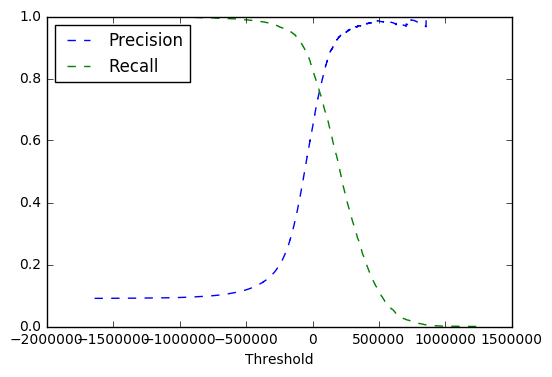

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
y_train_pred_90 = (y_scores > 70000)

In [27]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.791475801633
0.733075078399


### The Roc Curve 

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

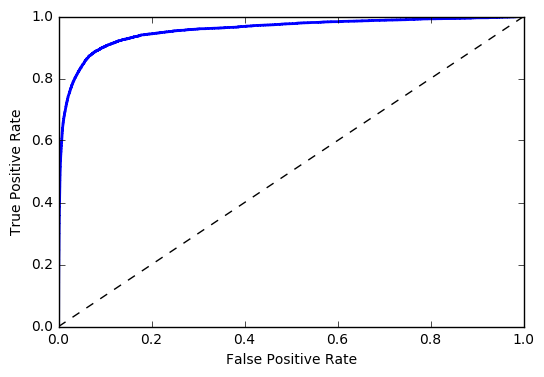

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95651609481222966

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [32]:
# getting the scores
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

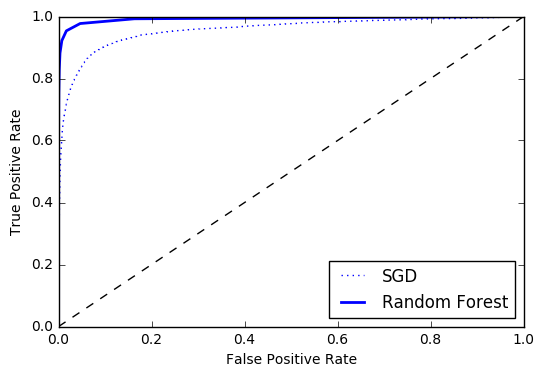

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.99257097203734124

In [35]:
# calculating precision and recall
y_train_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print("Precision: {}".format(precision_score(y_train_5, y_train_pred)))
print("Recall: {}".format(recall_score(y_train_5, y_train_pred)))
print("F1 Score: {}".format(f1_score(y_train_5, y_train_pred)))

Precision: 0.9840017532325225
Recall: 0.8282604685482383
F1 Score: 0.8994391025641025


## MulitClass Classification 

In [36]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [37]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-244428.90058731, -539313.395463  , -320616.12180654,
        -148515.73792852, -293429.07589036,   65633.72449137,
        -878532.04424759, -266147.20868283, -724878.20758043,
        -786545.68227628]])

In [38]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

5
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
5.0


In [39]:
# forcing the use of OvO classifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[ 5.]
45


In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [41]:
# getting the list of probabilities that each classifier assigned to each
# class

forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0.1,  0.2,  0. ,  0.5,  0. ,  0. ,  0.1,  0. ]])

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.83993201,  0.86634332,  0.88063209])

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90936813,  0.91059553,  0.90808621])

In [44]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Error Analysis 

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5729,    3,   23,    9,   13,   39,   49,   10,   44,    4],
       [   2, 6481,   41,   22,    6,   40,    6,    8,  124,   12],
       [  50,   39, 5310,  124,   80,   30,   96,   58,  159,   12],
       [  52,   41,  138, 5347,    3,  228,   39,   51,  135,   97],
       [  18,   25,   37,   11, 5359,    8,   47,   32,   98,  207],
       [  65,   44,   28,  193,   79, 4610,  110,   28,  177,   87],
       [  33,   25,   48,    2,   44,   99, 5615,    4,   48,    0],
       [  24,   18,   74,   32,   55,   11,    5, 5790,   19,  237],
       [  44,  143,   76,  163,   11,  162,   51,   22, 5048,  131],
       [  41,   31,   28,   89,  164,   37,    2,  201,   84, 5272]])

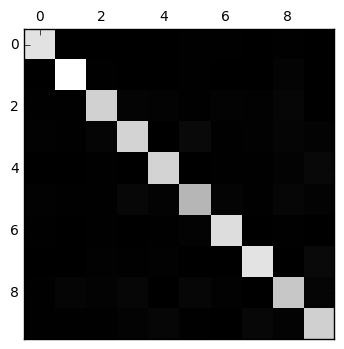

In [46]:
# image representation of confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [47]:
# dividing each value in the confusion matrix by the number of images
# in the corresponding class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

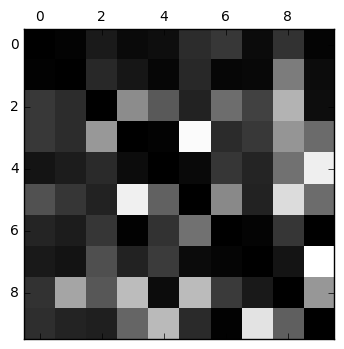

In [48]:
# filling diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The columns for classes 8 and 9 are quite bright, which tells you that many images get misclassified as 8s or 9s. Similarly, the rows for classes 8 and 9 are also quite bright, telling you that 8s and 9s are often confused with other digits. Conversely, some rows are pretty dark, such as row 1: this means that most 1s are classified correctly (a few are confused with 8s, but that’s about it). Notice that the errors are not perfectly symmetrical; for example, there are more 5s misclassified as 8s than the reverse.

## Multilabel Classification 

In [49]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# making_prediction
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
# computing the F1 score average
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

## Multioutput Classification 

In [10]:
# adding noise to MNIST images
noise = rnd.randint(0, 100, (len(X_train), 784))
noise = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_tes

NameError: name 'rnd' is not defined

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
print(clean_digit)